*Please, refer to `project.pdf` to know more about the context and the instructions.*

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
sns.set_style("darkgrid")

In [100]:
# Install the Open Food Facts Python package
!pip install openfoodfacts -q

In [101]:
# Setup the API for data extraction
from openfoodfacts import API, APIVersion, Country, Environment, Flavor

api = API(
    username=None,
    password=None,
    country=Country.world,
    flavor=Flavor.off,
    version=APIVersion.v2,
    environment=Environment.org,
)

In [102]:
# Food and drinks data from the API (10*2000 = 2000 products retrieved)
products = []
print("Extraction started...")
for i in range(10):
    print(f"Page {i+1}/10", end="")
    results = api.product.text_search(query="", page=i+1, page_size=200)
    print(" -- Done. Appending results")
    products += results["products"]
    if i == 9:
        print("Extraction done successfully!")

Extraction started...
Page 1/10 -- Done. Appending results
Page 2/10 -- Done. Appending results
Page 3/10 -- Done. Appending results
Page 4/10 -- Done. Appending results
Page 5/10 -- Done. Appending results
Page 6/10 -- Done. Appending results
Page 7/10 -- Done. Appending results
Page 8/10 -- Done. Appending results
Page 9/10 -- Done. Appending results
Page 10/10 -- Done. Appending results
Extraction done successfully!


In [105]:
# Columns of interest
columns = [
    # Product identification
    "product_name",

    # Nutriscore data
    "energy_points",
    "saturated_fat_points",
    "sugars_points",
    "sodium_points",
    "proteins_points",
    "fiber_points",
    "fruits_vegetables_nuts_points",
    "nutriscore_score", "nutriscore_grade",
    
    # Nutrient levels info (tricolor method)
    "fat_level", "salt_level", "saturated_fat_level", "sugars_level"
]

In [106]:
# Nustriscore data
ns = []

for i, p in enumerate(products):
    # Extract the product category (the first) to drop drinks
    cat = p.get("categories_hierarchy")
    if cat is not None:
        if len(cat) > 0 and ("beverage" in cat[0] or "boissons" in cat[0]):
            continue # pass, keep food only
    
    # Additional security: drop if the quantity contains "l" (liters)
    quant = p.get("quantity")
    if quant is not None:
        if "l" in quant:
            continue
    
    # Product identification
    id_info = [p.get("product_name")]
    
    # Nutriscore data
    ns_data = p.get("nutriscore_data")
    if ns_data is not None:
        ns_info = [
            ns_data.get("energy_points"),
            ns_data.get("saturated_fat_points"),
            ns_data.get("sugars_points"),
            ns_data.get("sodium_points"),
            ns_data.get("proteins_points"),
            ns_data.get("fiber_points"),
            ns_data.get("fruits_vegetables_nuts_colza_walnut_olive_oils_points"),
        ]
    else:
        continue
    ns_info += [p.get("nutriscore_score"), p.get("nutriscore_grade")]

    # Nutrient levels info (tricolor method)
    tri_data = p.get("nutrient_levels")
    if tri_data is not None:
        tri_info = [tri_data.get("fat"), tri_data.get("salt"), tri_data.get("saturated-fat"), tri_data.get("sugars")]
    else:
        continue
    
    # Complete product information
    product = id_info + ns_info + tri_info
    
    # Append new product to existing ones
    ns.append(product)

# Final dataset
ns = pd.DataFrame(ns, columns=columns)

In [107]:
# Length of output at this step
len(ns)

924

In [108]:
# Missing values
print(ns.isnull().sum())
ns.dropna(inplace=True)

product_name                     70
energy_points                    13
saturated_fat_points             32
sugars_points                    13
sodium_points                    13
proteins_points                  13
fiber_points                     13
fruits_vegetables_nuts_points    13
nutriscore_score                 13
nutriscore_grade                  0
fat_level                         6
salt_level                        6
saturated_fat_level               6
sugars_level                      7
dtype: int64


In [109]:
# Duplicates
print(ns.duplicated().sum())
ns.drop_duplicates(inplace=True)

33


In [110]:
# Variables type
ns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 789 entries, 0 to 923
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_name                   789 non-null    object 
 1   energy_points                  789 non-null    float64
 2   saturated_fat_points           789 non-null    float64
 3   sugars_points                  789 non-null    float64
 4   sodium_points                  789 non-null    float64
 5   proteins_points                789 non-null    float64
 6   fiber_points                   789 non-null    float64
 7   fruits_vegetables_nuts_points  789 non-null    float64
 8   nutriscore_score               789 non-null    float64
 9   nutriscore_grade               789 non-null    object 
 10  fat_level                      789 non-null    object 
 11  salt_level                     789 non-null    object 
 12  saturated_fat_level            789 non-null    obj

In [137]:
# Change some types to int
## Nutrient points
for col in ns.columns:
    if col.endswith("points"):
        ns[col] = ns[col].astype(int)

## Nutriscore calculated value
ns["nutriscore_score"] = ns["nutriscore_score"].astype(int)

In [138]:
# Preview
ns.head()

,product_name,energy_points,saturated_fat_points,sugars_points,sodium_points,proteins_points,fiber_points,fruits_vegetables_nuts_points,nutriscore_score,nutriscore_grade,fat_level,salt_level,saturated_fat_level,sugars_level
0,Nutella,6,10,10,0,3,0,0,26,e,high,low,high,high
1,Prince Chocolat biscuits au blé complet,5,5,7,2,3,4,0,15,d,moderate,moderate,high,high
3,"Gerblé - Sesame Cookie, 230g (8.2oz)",5,1,3,1,5,4,0,1,b,moderate,moderate,moderate,high
4,"Ferrero- Nutella Biscuits Resealable Bag, 304g...",6,10,7,2,4,0,0,25,e,high,moderate,high,high
5,Nocciolata Pâte À Tartiner Au Cacao Et Noisettes,6,5,10,0,5,3,0,18,d,high,low,high,high


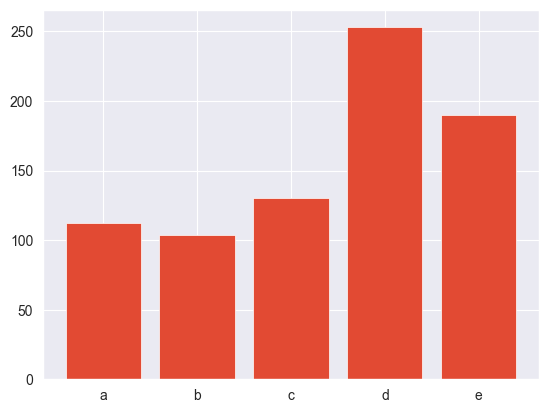

In [113]:
# Nutriscore distribution
x = ns["nutriscore_grade"].value_counts().sort_index()
plt.bar(x.index, x.values)
plt.show()

## Extreme profiles ($d_1, d_2, ..., d_6$)

![](nutri-score-limits.png)

<i>Source: https://get.apicbase.com/fr/nutriscore-systeme-etiquetage-valeur-nutritionnelle</i>

In [114]:
limits = [(18, 19), (10, 11), (2, 3), (-1, 0)] # limits between grades
cols = ["energy_points", "saturated_fat_points", "sugars_points", "sodium_points",
        "proteins_points", "fiber_points", "fruits_vegetables_nuts_points"]

In [143]:
# The worst and best possible food are defined as follows
worst = pd.Series(data=[10, 10, 10, 10, 0, 0, 0], index=cols)
best = pd.Series(data=[0, 0, 0, 0, 5, 5, 5], index=cols)

*To find the charecteristics of the ideal intermediary food between two classes (middle profiles), we've decided to take, for each nutrient, the median of the points of products located exactly on either side of the scores limits. Of course, this method is debatable.*

e.g. The energy value of the extreme profile between A and B will be the average of energy points carried by food products with scores -1 and 0.

In [146]:
middle = [ns.loc[ns["nutriscore_score"].isin(limit), cols].median()
          for limit in limits]

In [147]:
# Middle food between nutriscores A and B
middle[3]

energy_points                    1.0
saturated_fat_points             1.0
sugars_points                    1.0
sodium_points                    1.0
proteins_points                  4.0
fiber_points                     1.0
fruits_vegetables_nuts_points    0.0
dtype: float64

In [148]:
# Extreme profiles (reference products)
ref = pd.DataFrame([worst] + middle + [best], index=[f"b{i+1}" for i in range(6)])
ref

,energy_points,saturated_fat_points,sugars_points,sodium_points,proteins_points,fiber_points,fruits_vegetables_nuts_points
b1,10.0,10.0,10.0,10.0,0.0,0.0,0.0
b2,6.0,6.0,6.0,1.0,4.0,2.0,0.0
b3,5.0,3.0,3.0,3.0,4.0,4.5,0.0
b4,1.0,1.0,0.0,3.0,4.0,0.0,0.0
b5,1.0,1.0,1.0,1.0,4.0,1.0,0.0
b6,0.0,0.0,0.0,0.0,5.0,5.0,5.0


In [ ]:
# Indice de concordance partiel
def c_p(j, H, i):
    if j < 4: # fonction à minimiser
        return int(ref.iloc[i, j] >= H[j])
    else: # fonction à maximiser
        return int(ref.iloc[i, j] <= H[j])

In [ ]:
def C_G(H, i, k):
    C = 0
    for j in range(len(H)):
        C += k[j] * c_p(j, H, i)
    C /= sum(k)
    return C

In [ ]:
def H_surclasse_bi(H, i, k, s): # s pour seuil
    return C_G(H, i, k) >= s

In [ ]:
nutri_scores = ["E", "D", "C", "B", "A"]

In [ ]:
def PessimisticMajoritySorting(H, k, s):
    for i in range(len(k)-3, 0, -1):
        if H_surclasse_bi(H, i, k, s):
            return nutri_scores[i]
    return "E"

In [ ]:
def OptimisticMajoritySorting(H, k, s):
    for i in range(1, 5):
        if not H_surclasse_bi(H, i, k, s):
            return nutri_scores[i-1]
    return "A"

In [ ]:
nutri = ns["nutriscore_grade"].str.upper()

In [ ]:
k = [1, 10, 5, 1, 5, 3, 1]
s = .6
opt = ns[cols].apply(lambda H: OptimisticMajoritySorting(H, k, s), axis=1)
pes = ns[cols].apply(lambda H: PessimisticMajoritySorting(H, k, s), axis=1)

In [ ]:
(opt != nutri).sum()

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(ns["nutriscore_grade"].str.upper(), opt)